Copyright © 2023 "Bronte" Sihan Li

## Introduction
In this project, we will combine all the knowledge learned from previous lessons and implement some classic machine learning techniques to perform two-class classification on the heart disease prediction dataset.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
os.chdir('..')
from project3.utility.colors import color_list1
from project1.utility.pca import PCA
from prince import FAMD

## Pre-processing, Data Mining, and Visualization

In [3]:
# Load training set
train_data = pd.read_csv('project3/data/heart_train.csv')
train_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,66,F,NAP,146,278,0,LVH,152,N,0.0,Flat,0
1,65,M,ASY,150,235,0,Normal,120,Y,1.5,Flat,1
2,63,M,ASY,150,223,0,Normal,115,N,0.0,Flat,1
3,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
4,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1


In [4]:
train_data['HeartDisease'].value_counts()

1    403
0    315
Name: HeartDisease, dtype: int64

### Initial Visualization
As we can see here, there are both numerical and categorical features here. Let's take a look at the value ranges for each variable.

In [6]:
NUMERICAL_COLS = []
CATEGORICAL_COLS = []
for col in train_data.drop(columns=['HeartDisease']).columns:
    print(col, train_data[col].unique())
    if type(train_data[col].unique()[0]) == str:
        print(train_data[col].value_counts())
        CATEGORICAL_COLS.append(col)
    else:
        NUMERICAL_COLS.append(col)


Age [66 65 63 58 54 38 51 62 55 52 46 60 59 36 43 41 47 49 45 53 40 61 57 64
 69 74 75 33 56 35 39 37 50 32 42 76 28 34 72 71 48 44 70 30 67 68 31 77
 29]
Sex ['F' 'M']
M    575
F    143
Name: Sex, dtype: int64
ChestPainType ['NAP' 'ASY' 'ATA' 'TA']
ASY    389
NAP    154
ATA    136
TA      39
Name: ChestPainType, dtype: int64
RestingBP [146 150 136 192 105 100 130 110 140 120 115 112 155 134 125 160 106 200
 142 154 145 104 156 135  80 148 122 118 124 137  95 152 132 126 131 172
 128 170 138 133 114 174 180 108 141 144 101 139 178 190 165 158 143  92
 123  96 102 164 127 117 113   0 185]
Cholesterol [278 235 223 164 283   0 213 224 203 214 100 230 284 293 169 308 204 267
 315 268 211 271 253 237 212 246 264 254 240 177 186 210 247 276 231 338
 303 216 208 173 201 310 298 274 192 225 289 219 160 207 185 281 341 245
 282 295 257 197 312 132 233 221 238 417 152 297 199 184 161 123 180 412
 262 306 232 342 159 258 458 249 327 181 209 260 166 248 266 141 222 234
 182 218 318 564 518 316 294

There are a few observations we can draw:
* There are some missing values (0) in `RestingBP` and `Cholesterol`
* `FastingBS` is a categorical feature
* Each numerical feature is on a different scale

In [7]:
# Move "fasting blood sugar" to categorical
NUMERICAL_COLS.remove('FastingBS')
CATEGORICAL_COLS.append('FastingBS')

# Replace missing values with mean
for col in ['Cholesterol', 'RestingBP']:
    train_data[col].replace(to_replace=0, value=train_data[col].mean(), inplace=True)

Now that we have a better idea of what our variables are like, let's plot each of them.

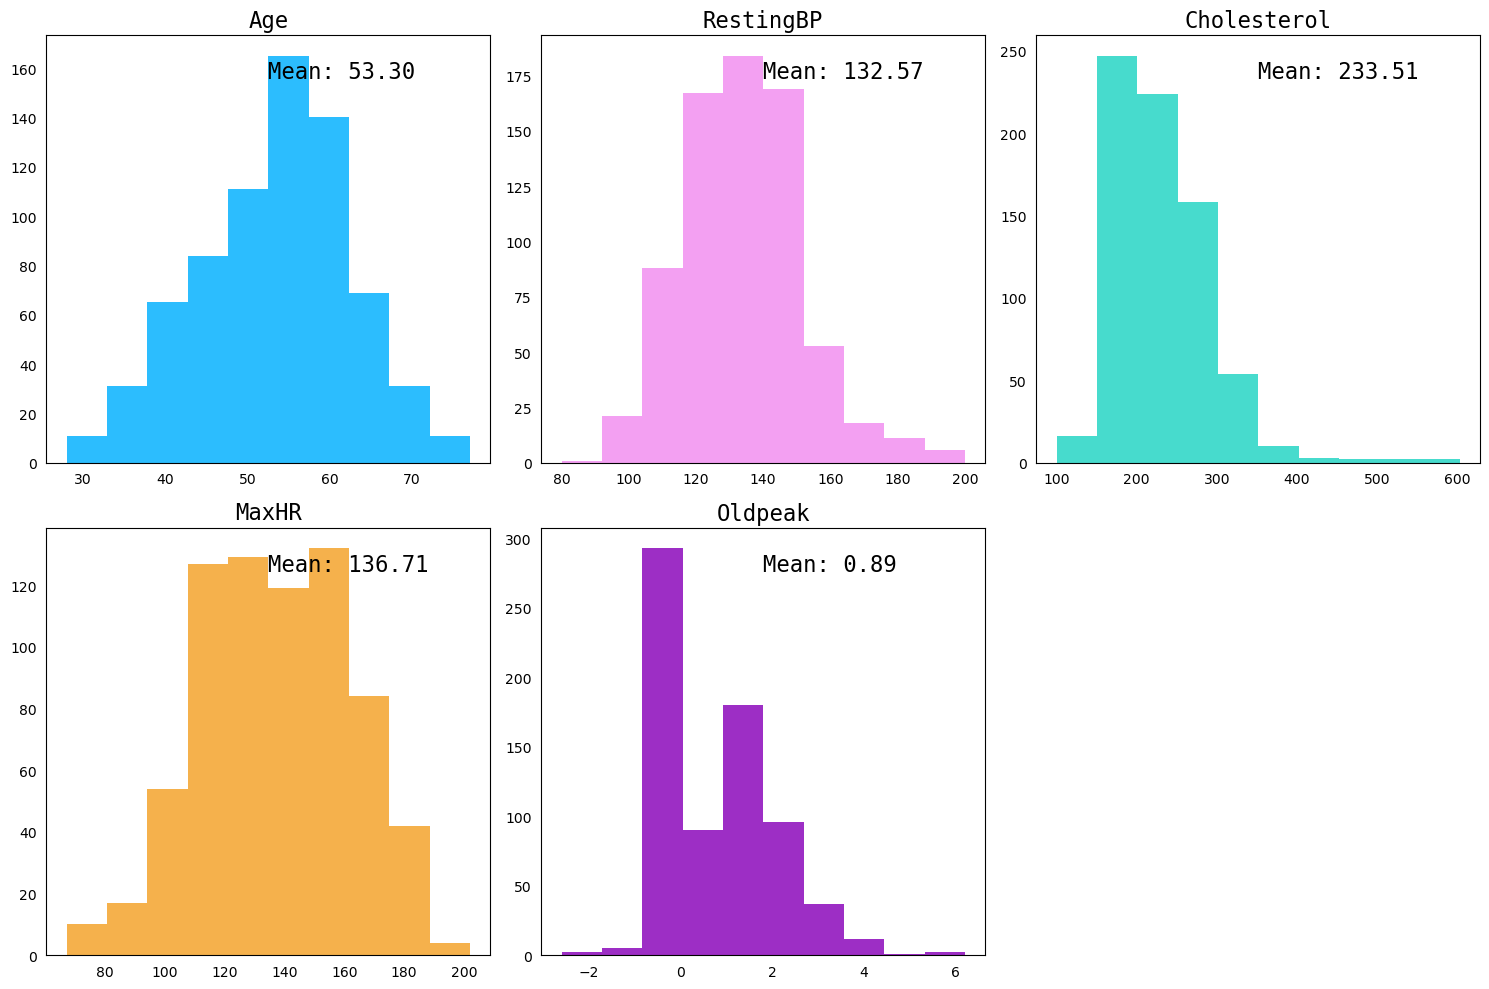

In [8]:
font_dict = {'family': 'monospace', 'color': 'black', 'size': 16}
# Plot histograms of categorical columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(NUMERICAL_COLS):
    ax = axes[i // 3, i % 3]
    ax.hist(train_data[col], color=color_list1[i])
    ax.set_title(col, fontdict=font_dict)
    ax.text(0.5, 0.9, f'Mean: {train_data[col].mean():.2f}', transform=ax.transAxes, fontdict=font_dict)
    ax.tick_params(left=False, bottom=False)
# Remove empty axes
fig.delaxes(axes[1][2])
plt.tight_layout()
plt.show()

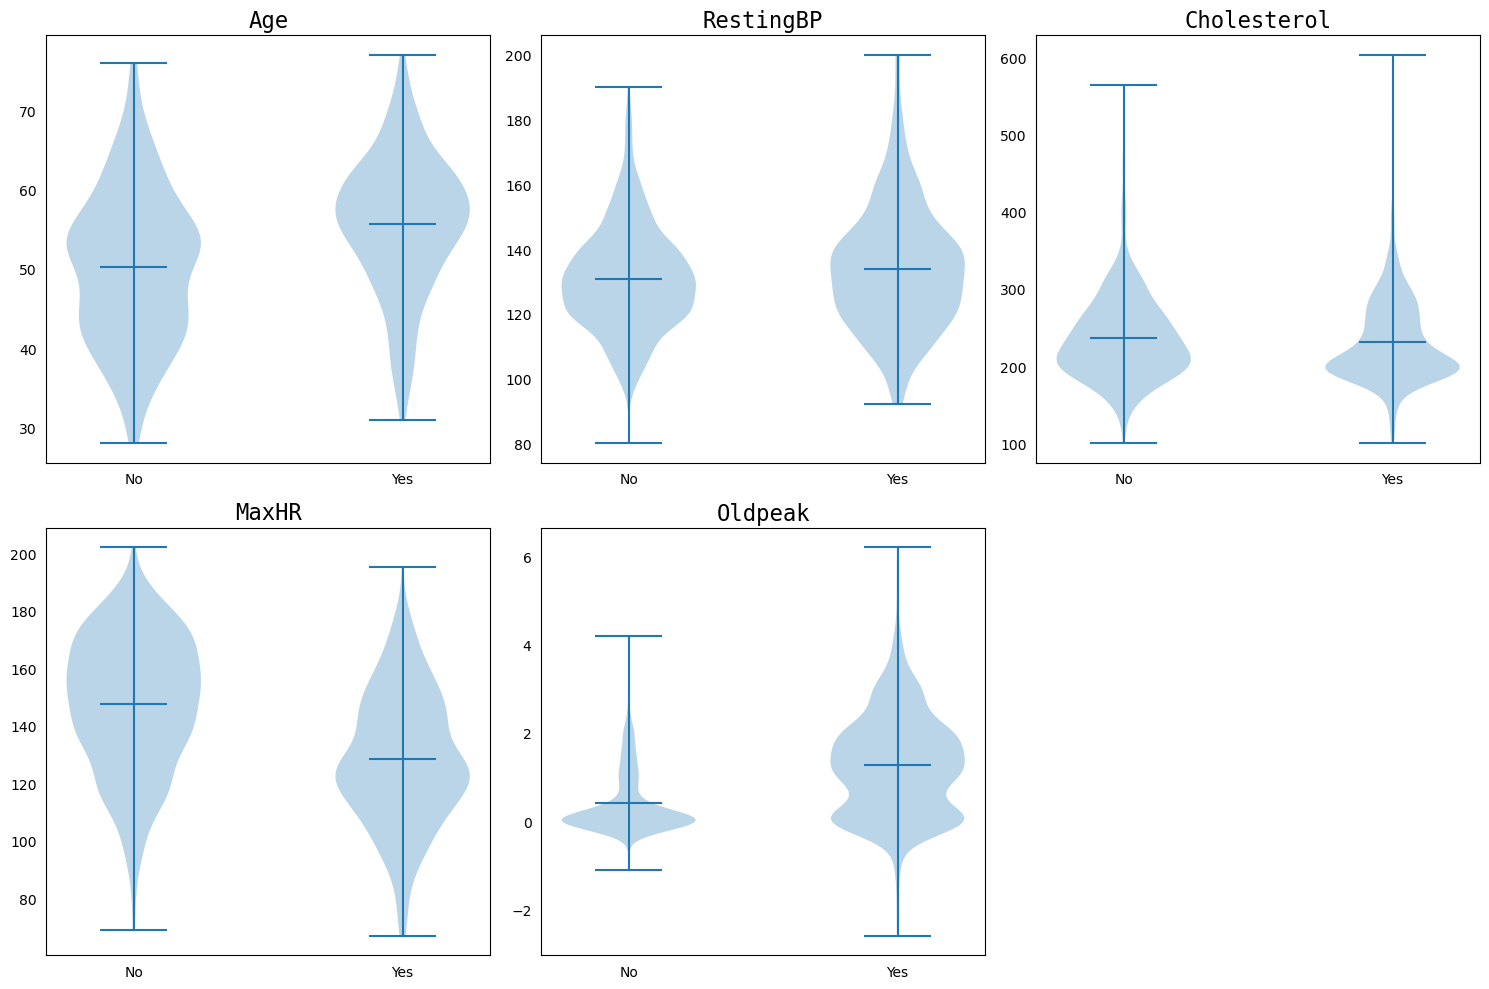

In [9]:
# Plot violin plots of numerical columns against HeartDisease
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(NUMERICAL_COLS):
    ax = axes[i // 3, i % 3]
    ax.violinplot([train_data[train_data['HeartDisease'] == 0][col], train_data[train_data['HeartDisease'] == 1][col]], showmeans=True)
    ax.set_title(col, fontdict=font_dict)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['No', 'Yes'])
    ax.tick_params(left=False, bottom=False)
# Remove empty axes
fig.delaxes(axes[1][2])
plt.tight_layout()


As we mentioned, each of our numerical variables are on a different scale, so now we will standardize our data.

In [10]:
# Normalize numerical columns with standard scaler
sc = StandardScaler()
train_data[NUMERICAL_COLS] = sc.fit_transform(train_data[NUMERICAL_COLS])

Now we can look for correlations in our numerical features and visualize with a heatmap:

<AxesSubplot:>

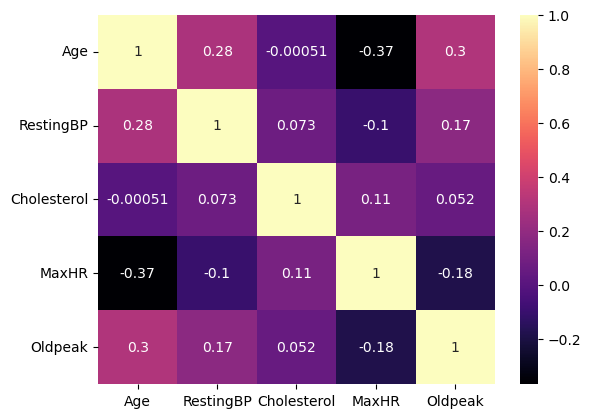

In [11]:
# Compute correlation confusion matrix of numerical columns with Spearman correlation
corr_matrix = train_data[NUMERICAL_COLS].corr(method='spearman')
# Plot correlation confusion matrix with heatmap
sns.heatmap(corr_matrix, cmap='magma', annot=True)


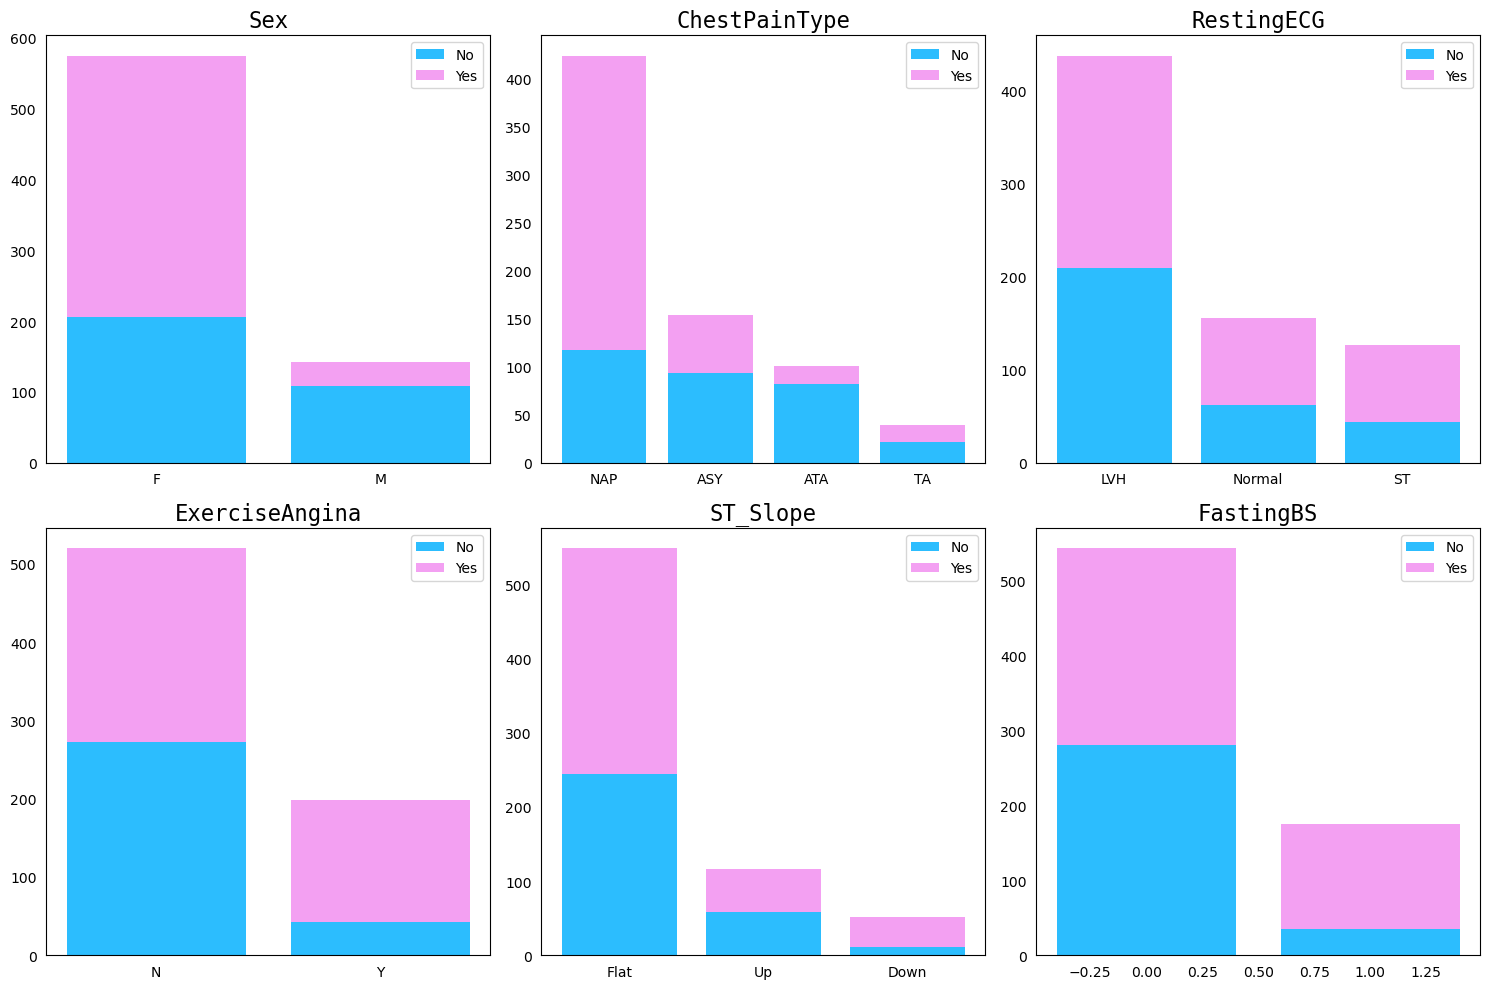

In [12]:
# Plot bar charts of categorical columns against target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(CATEGORICAL_COLS):
    ax = axes[i // 3, i % 3]
    # Stacked bar chart
    ax.bar(train_data[col].unique(), train_data[train_data['HeartDisease']==0][col].value_counts(), label='No', color=[color_list1[0]])
    ax.bar(train_data[col].unique(), train_data[train_data['HeartDisease']==1][col].value_counts(), label='Yes',
           bottom=train_data[train_data['HeartDisease']==0][col].value_counts(), color=[color_list1[1]])
    ax.set_title(col, fontdict=font_dict)
    ax.tick_params(left=False, bottom=False)
    ax.legend()
plt.tight_layout()
plt.show()

### Apply One-Hot Encoding Transformation

In [13]:
# Apply one-hot encoding to categorical columns
train_data_dummies = pd.get_dummies(train_data, columns=CATEGORICAL_COLS)
train_data_dummies.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS_0,FastingBS_1
0,1.350090,0.750995,0.792316,0.610516,-0.820203,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
1,1.243824,0.974744,0.026594,-0.666892,0.566545,1,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
2,1.031290,0.974744,-0.187096,-0.866487,-0.820203,1,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0
3,0.499957,0.191621,-1.237739,-1.505191,1.028795,1,0,1,0,1,...,0,0,1,0,1,0,1,0,1,0
4,0.074890,3.324112,0.881354,2.327033,-0.820203,1,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0


In [14]:
# Apply PCA
pca = PCA(data=train_data_dummies.drop(columns=['HeartDisease']))
projected = pca.do_pca()
# Plot first two principal components
fig = px.scatter(projected, x=0, y=1, color=train_data_dummies['HeartDisease'], color_continuous_scale='tealrose',)
fig.update_layout(title='PCA of Heart Disease Dataset', title_font_size=20)
fig.show()


In [16]:
print(f'The number of principal components to explain 90% of the variance is {pca.principal_components}')

The number of principal components to explain 90% of the variance is 12


### FAMD Analysis

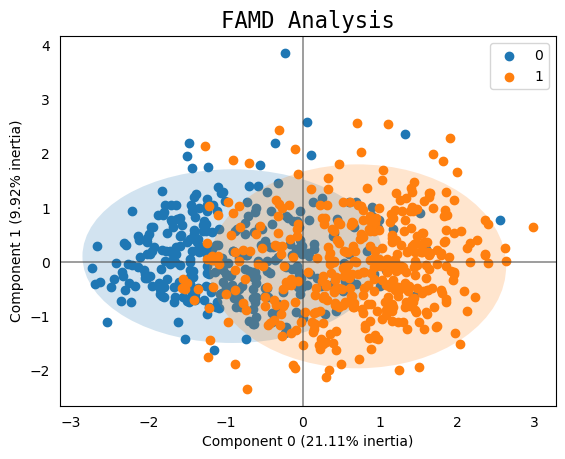

In [17]:
# Apply FAMD to data
famd = FAMD(n_components=2, n_iter=3, copy=True, check_input=True, engine='auto', random_state=42)
famd.fit(train_data.drop(columns=['HeartDisease']))
projected_famd = famd.transform(train_data.drop(columns=['HeartDisease']))
fig, ax = plt.subplots()
famd.plot_row_coordinates(train_data, ax=ax, color_labels=train_data['HeartDisease'],)
ax.set_title('FAMD Analysis', fontdict=font_dict)
ax.grid(False)

### Feature Selection with Recursive feature elimination with cross-validation (RFECV)

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

min_features_to_select = 1
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
estimator = LogisticRegression(max_iter=1000, random_state=42)
selector = RFECV(estimator, step=1, cv=cv, scoring='accuracy', min_features_to_select=min_features_to_select)
selector = selector.fit(projected, train_data_dummies['HeartDisease'])
print(f'Optimal number of features: {selector.n_features_}')

Optimal number of features: 8


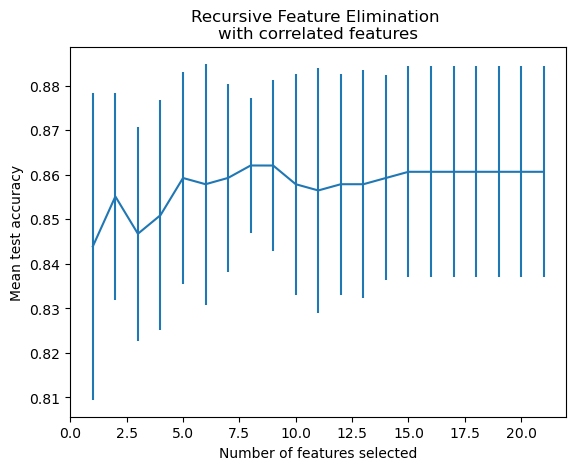

In [19]:
# Plot number of features VS. cross-validation scores
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [20]:
selected_features = selector.transform(projected)
selected_features.shape

(718, 8)

## Classification

We will be using the following classifiers for our task:

* Support Vector Machine
* Random forest
* Gradient Boosting
* XGBoost
* MLP

In [27]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(selected_features, train_data_dummies['HeartDisease'], test_size=0.2, random_state=42)

# # Transform test data
# val_data_dummies = pd.get_dummies(test_data, columns=CATEGORICAL_COLS)
# test_data_dummies[NUMERICAL_COLS] = sc.transform(test_data_dummies[NUMERICAL_COLS])
# projected_test = pca.transform(test_data_dummies.drop(columns=['HeartDisease']).to_numpy())
# selected_features_test = selector.transform(projected_test)
# selected_features_test.shape

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((574, 8), (144, 8), (574,), (144,))

In [28]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Define classifiers
classifiers = {
    'SVM': SVC(random_state=42, C=1.2),
    'RF': RandomForestClassifier(random_state=42, max_depth=100, n_estimators=100, criterion='entropy'),
    'GB': GradientBoostingClassifier(random_state=42, max_depth=2, learning_rate=0.2, criterion='friedman_mse'),
    'MLP': MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes=(20, 20, 20)),
    'XGBoost': XGBClassifier(random_state=42, eta=0.2, max_depth=4),
}    

# Define function to train and evaluate classifiers
def train_and_evaluate(classifiers, X_train, y_train, X_val, y_val):
    trained_classifiers = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        print(f'{name} accuracy: {clf.score(X_val, y_val):.3f}')
        y_pred = clf.predict(X_val)
        print(classification_report(y_val, y_pred))
        trained_classifiers[name] = clf
    return trained_classifiers
        

# Train and evaluate classifiers
trained_classifiers = train_and_evaluate(classifiers, X_train, y_train, X_val, y_val)


SVM accuracy: 0.861
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        63
           1       0.84      0.94      0.88        81

    accuracy                           0.86       144
   macro avg       0.87      0.85      0.86       144
weighted avg       0.87      0.86      0.86       144

RF accuracy: 0.840
              precision    recall  f1-score   support

           0       0.88      0.73      0.80        63
           1       0.82      0.93      0.87        81

    accuracy                           0.84       144
   macro avg       0.85      0.83      0.83       144
weighted avg       0.85      0.84      0.84       144

GB accuracy: 0.833
              precision    recall  f1-score   support

           0       0.88      0.71      0.79        63
           1       0.81      0.93      0.86        81

    accuracy                           0.83       144
   macro avg       0.84      0.82      0.83       144
weighted avg    

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



MLP accuracy: 0.875
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        63
           1       0.86      0.93      0.89        81

    accuracy                           0.88       144
   macro avg       0.88      0.87      0.87       144
weighted avg       0.88      0.88      0.87       144

XGBoost accuracy: 0.847
              precision    recall  f1-score   support

           0       0.89      0.75      0.81        63
           1       0.82      0.93      0.87        81

    accuracy                           0.85       144
   macro avg       0.86      0.84      0.84       144
weighted avg       0.85      0.85      0.85       144



## Evaluation

In [33]:
# Compute confusion matrix, F1 score, bias and variance for each classifier

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from mlxtend.evaluate import bias_variance_decomp

# Create dataframe with results
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'F1 Score', 'Bias', 'Variance'])

# Calculate bias and variance with bias-variance decomposition
for name, clf in trained_classifiers.items():
    y_pred = clf.predict(X_val)
    expected_loss, bias, variance = bias_variance_decomp(clf, X_train, y_train.to_numpy(), X_val, y_val.to_numpy(), loss='0-1_loss', num_rounds=100, random_seed=42)
    print(f'{name} confusion matrix:\n {confusion_matrix(y_val, y_pred)}')

    # Add results to Dataframe
    results = results.append({'Classifier': name, 'Accuracy': clf.score(X_val, y_val),
                              'F1 Score': f1_score(y_val, y_pred), 'Bias': bias, 'Variance': variance}, ignore_index=True)


SVM confusion matrix:
 [[49 14]
 [ 6 75]]
RF confusion matrix:
 [[46 17]
 [ 6 75]]
GB confusion matrix:
 [[45 18]
 [ 6 75]]


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptro

MLP confusion matrix:
 [[51 12]
 [ 6 75]]
XGBoost confusion matrix:
 [[47 16]
 [ 6 75]]


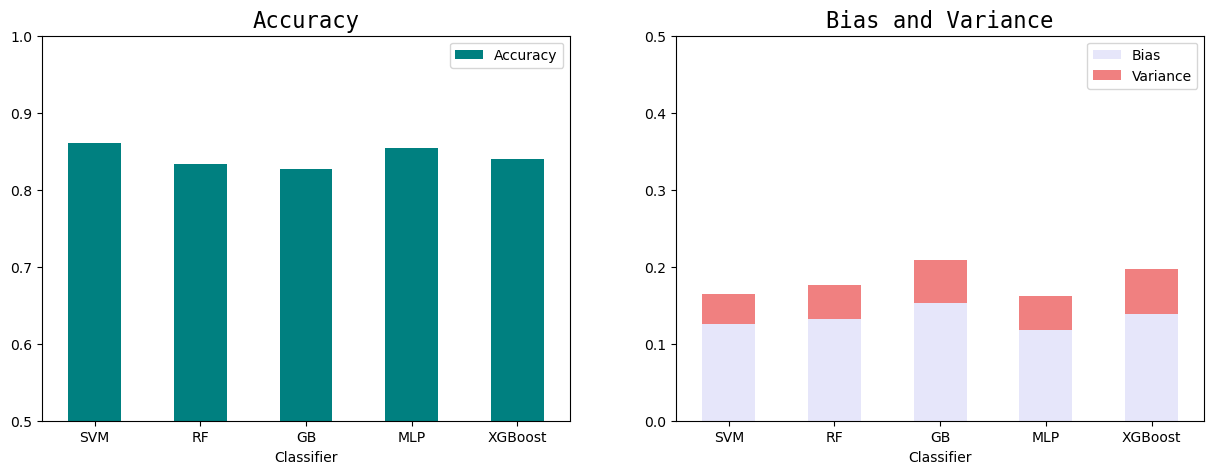

In [34]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
results.plot.bar(x='Classifier', y='Accuracy', ax=ax[0], rot=0, color='teal')
results.plot.bar(x='Classifier', y='Bias', ax=ax[1], rot=0, color='lavender')
results.plot.bar(x='Classifier', y='Variance', ax=ax[1], rot=0, color='lightcoral', bottom=results['Bias'])
ax[0].set_title('Accuracy', fontdict=font_dict)
ax[1].set_title('Bias and Variance', fontdict=font_dict)
ax[0].set_ylim(0.5, 1)
ax[1].set_ylim(0, 0.5)
plt.show()


In [36]:
results.head()

,Classifier,Accuracy,F1 Score,Bias,Variance
0,SVM,0.861111,0.882353,0.125000,0.039722
1,RF,0.833333,0.867052,0.131944,0.043958
2,GB,0.826389,0.862069,0.152778,0.055556
3,MLP,0.854167,0.892857,0.118056,0.044167
4,XGBoost,0.840278,0.872093,0.138889,0.057708


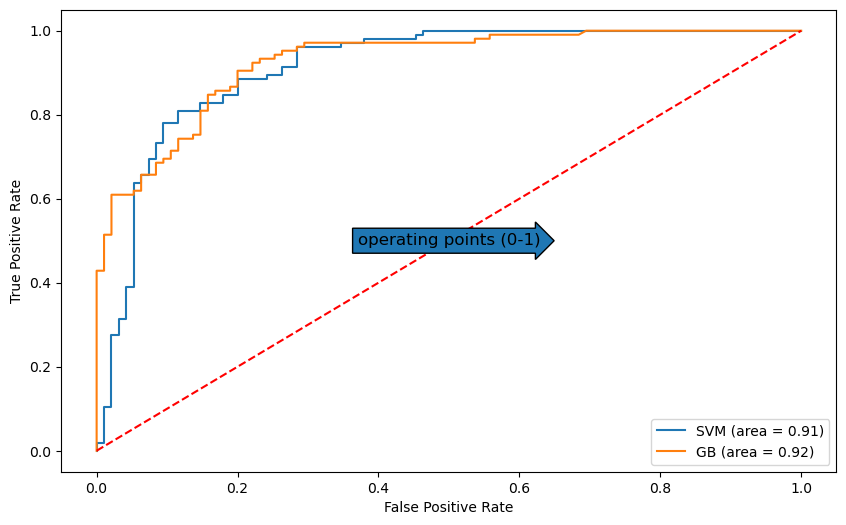

In [37]:
# Build ROC curve for SVM and Gradient Boosting classifiers
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize = (10,6))
for name, clf in trained_classifiers.items():
    if name not in ['RF', 'MLP', 'XGBoost']:
        fpr, tpr, thresholds = roc_curve(test_data_dummies['HeartDisease'], clf.decision_function(selected_features_test))
        roc_auc = roc_auc_score(test_data_dummies['HeartDisease'], clf.decision_function(selected_features_test))
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1],'r--') 
plt.text(0.5, 0.5, "operating points (0-1)", rotation=0, size=12,ha="center", va="center",bbox=dict(boxstyle="rarrow"))
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc="lower right") 
plt.show()


## Iteration

In [39]:
print(classifiers['RF'].get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [41]:
# Apply random grid search for hyperparameter tuning on Random Forest Classifier
from sklearn.model_selection import RandomizedSearchCV
hyperparameters = {
    'bootstrap': [True, False],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000],
    'max_depth': [5, 10, 15, 20, 25, 50, 75, 100, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    }

rf_random = RandomizedSearchCV(estimator=classifiers['RF'], param_distributions=hyperparameters, n_iter=100,
                               cv=3, random_state=42, n_jobs=-1, scoring='accuracy')
rf_random.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_depth=100,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 25, 50, 75,
                                                      100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600,

In [42]:
print(classification_report(y_val, rf_random.predict(X_val)))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        63
           1       0.83      0.94      0.88        81

    accuracy                           0.85       144
   macro avg       0.86      0.84      0.85       144
weighted avg       0.86      0.85      0.85       144



In [ ]:
print(rf_random.best_params_)

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini', 'bootstrap': True}


In [47]:
# Perform grid search based on best parameters from random search
from sklearn.model_selection import GridSearchCV
hyperparameters_grid = {
    'bootstrap': [True],
    'n_estimators': [100, 200, 300],
    'max_depth': [30, 50, 70],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto'],
    'criterion': ['gini'],
    }

rf_grid = GridSearchCV(estimator=classifiers['RF'], param_grid=hyperparameters_grid, cv=3, n_jobs=-1, scoring='accuracy')
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy',
                                              max_depth=100, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [30, 50, 70], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [49]:
print(classification_report(y_val, rf_grid.predict(X_val)))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        63
           1       0.83      0.94      0.88        81

    accuracy                           0.85       144
   macro avg       0.86      0.84      0.85       144
weighted avg       0.86      0.85      0.85       144



In [ ]:
print(rf_grid.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}


In [50]:
# Perform k fold cross validation with the best Random Forest
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(rf_grid, selected_features, train_data_dummies['HeartDisease'], cv=cv, scoring='accuracy')
print(f'Random Forest accuracy: {scores.mean():.3f} +/- {scores.std():.3f}')

# Plot accuracy for each fold
fig = px.line(x=range(1, k+1), y=scores, title='Random Forest Accuracy for each fold', labels={'x': 'Fold', 'y': 'Accuracy'})
fig.show()

Random Forest accuracy: 0.854 +/- 0.023


## References
1. https://www.kaggle.com/code/jiagengchang/heart-disease-multiple-correspondence-analysis/notebook
2. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
3. https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210
4. https://towardsdatascience.com/factor-analysis-of-mixed-data-5ad5ce98663c
5. https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
6. https://pub.towardsai.net/bias-variance-decomposition-101-a-step-by-step-computation-9d5f3694877
7. https://www.bmc.com/blogs/bias-variance-machine-learning/
8. https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9
9. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
10. https://medium.com/@data.science.enthusiast/auc-roc-curve-ae9180eaf4f7
11. https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365